
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>
 
 
# Laboratorio: Análisis y Modelado de Series Temporales con SARIMAX

En este laboratorio, practicarás el análisis y modelado de series temporales utilizando el modelo SARIMAX. 
Objetivos del laboratorio

- Analizar series temporales:
	
    - Identificar tendencias, estacionalidad y posibles rupturas estructurales en los datos.
	
    - Verificar la estacionaridad de la serie mediante pruebas estadísticas y visuales.
	
    - Realizar análisis de autocorrelación (ACF) y autocorrelación parcial (PACF).

- Modelar la serie temporal:
	
    - Ajustar un modelo SARIMAX adecuado para los datos proporcionados.
	
    - Evaluar los resultados del modelo e interpretar los parámetros obtenidos.

- Interpretar gráficas y resultados:
	
    - Explicar de forma detallada el significado de las gráficas y resultados generados durante cada etapa del análisis.



In [71]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product


# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm

import sys
sys.path.append("../")
import src.soporte_sarima as ss

In [72]:
df = pd.read_csv("../datos/Truck_sales.csv")
df.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


# Preparación del DF
### Poner en formato fecha

In [73]:
df["Month-Year"] = pd.to_datetime(df["Month-Year"],format="%y-%b")

### Poner como index y Ordenar 

In [74]:
#df.set_index("Month-Year",inplace=True)
#df.sort_index(inplace=True)

In [75]:
#df.head()

# Parte 1: Carga y exploración inicial de los datos

- Descarga el conjunto de datos proporcionado, que contiene una serie temporal de valores relacionados con ventas mensuales de una empresa ficticia durante los últimos 5 años.

- Realiza una exploración inicial:

    - Gráfica la serie temporal completa para identificar posibles tendencias y estacionalidades.

    - Comenta tus observaciones iniciales sobre los patrones que encuentres.

In [76]:
explorar = ss.TimeSeriesAnalysis(df,"Month-Year","Number_Trucks_Sold")

In [77]:
explorar.exploracion_datos()

El número de filas es 144 y el número de columnas es 1

----------

En este conjunto de datos tenemos 21 valores duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Number_Trucks_Sold,144.0,428.729167,188.633037,152.0,273.5,406.0,560.25,958.0


### Gestión duplicados
- Ninguna son valores totalmente válidos

In [78]:
explorar.comprobar_serie_continua()

La serie temporal es continua, no faltan meses.


In [79]:
explorar.graficar_serie()

# Sobre los datos
- No son estacionarios, por lo tanto tienen tendencia
- Parecen tener estacionalidad

In [80]:
explorar.graficar_media_movil()

# Sobre la gráfica
- La evolución de la media nos indica que hay una tendencia a que la cantidad de Trucks Vendidos ha ido en aumento

In [81]:
df_copia = df.copy()
df_copia["Month"] = df_copia["Month-Year"].dt.month_name()
df_copia["Year"] = df_copia["Month-Year"].dt.year

<Axes: xlabel='Month', ylabel='Number_Trucks_Sold'>

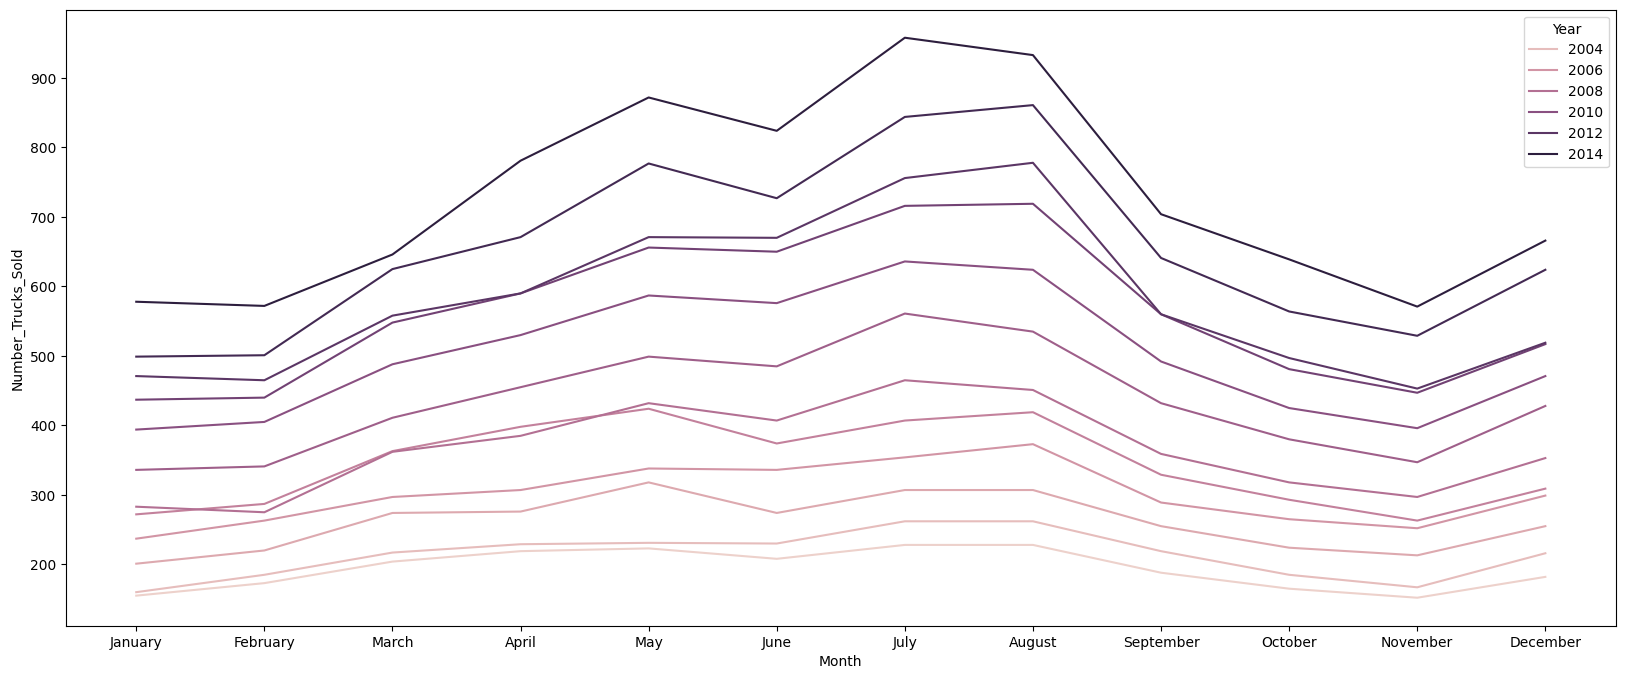

In [82]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=df_copia["Month"],y=df_copia["Number_Trucks_Sold"], hue=df_copia["Year"])

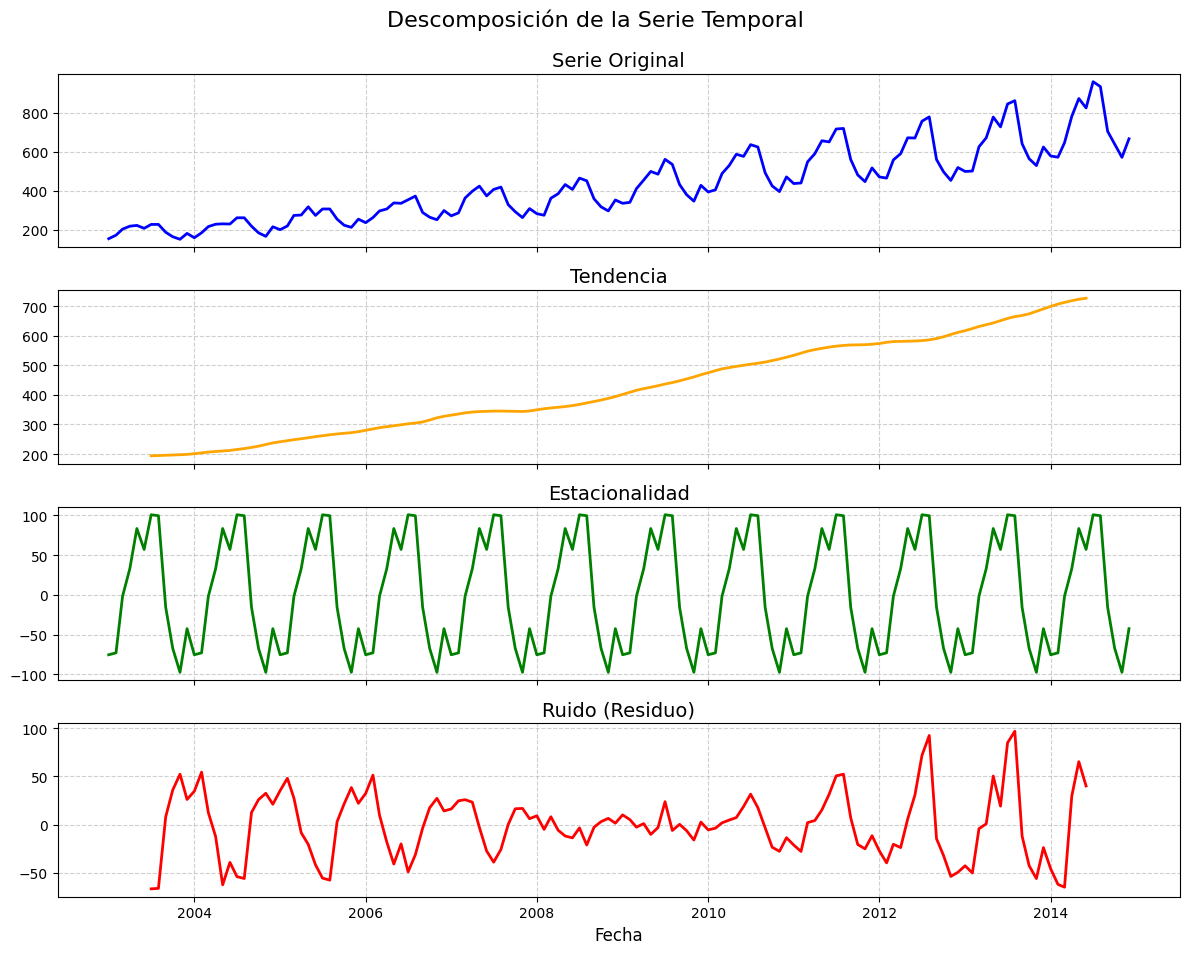

In [83]:
explorar.detectar_estacionalidad()

# Confirmamos Estacionalidad

# Parte 2: Estacionaridad

- Evalúa si la serie es estacionaria:

- Aplica el test de Dickey-Fuller aumentado (ADF).

- Si es necesario, realiza transformaciones (diferenciación o logaritmos) para convertir la serie en estacionaria.

- Genera una gráfica comparativa que muestre la serie original y la transformada, indicando las diferencias visuales.

- Escribe una interpretación de los resultados del test ADF y de la gráfica.

In [84]:
df

,Month-Year,Number_Trucks_Sold
0,2003-01-01,155
1,2003-02-01,173
2,2003-03-01,204
3,2003-04-01,219
4,2003-05-01,223
...,...,...
139,2014-08-01,933
140,2014-09-01,704
141,2014-10-01,639
142,2014-11-01,571


In [85]:
estacionaridad = ss.TimeSeriesAnalysis(df,"Month-Year","Number_Trucks_Sold")
estacionaridad.prueba_estacionariedad()

ADF Statistic: 1.1158932574252591
p-value: 0.9953500083802601
Valores Críticos:
1%: -3.482087964046026
5%: -2.8842185101614626
10%: -2.578864381347275
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


### No es estacionaria
- Eso significa, que, como hemos observado antes nuestra serie tiene tendencia a crecer en el tiempo!

# Parte 3: Análisis de autocorrelaciones


- Genera los gráficos de ACF (Autocorrelation Function) y PACF (Partial Autocorrelation Function).

- Identifica:

    - El orden de diferenciación necesario (si aún no lo has hecho).

    - Los posibles valores para los parámetros p y q del modelo SARIMAX.

- Explica qué indican las autocorrelaciones encontradas y cómo las utilizarás para definir los parámetros del modelo.

<Figure size 1200x1000 with 0 Axes>

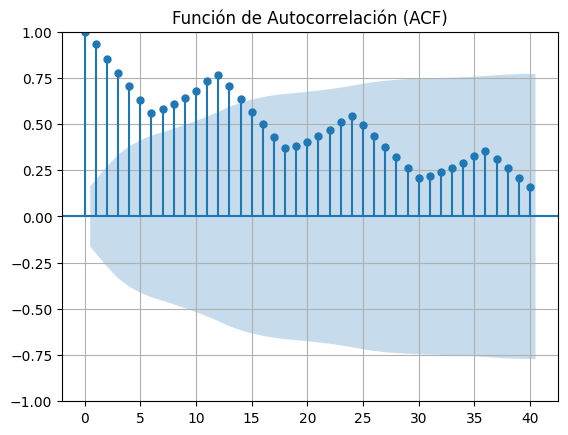

<Figure size 1200x1000 with 0 Axes>

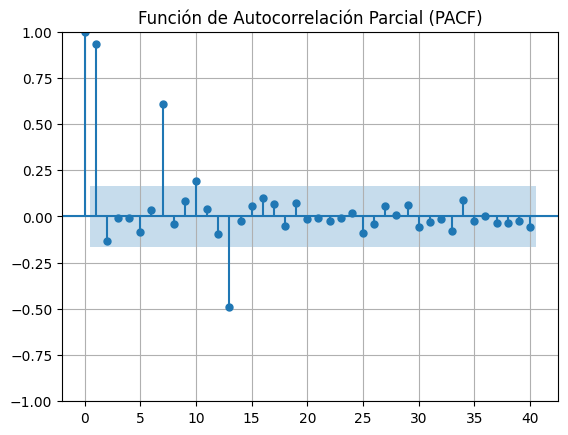

In [86]:
graficar = ss.TimeSeriesAnalysis(df,"Month-Year","Number_Trucks_Sold")
graficar.graficar_acf_pacf()

# Resultados de la observación
- q = 14
- p = 2

# Parte 4: Ajuste del modelo SARIMAX

- Ajusta un modelo SARIMAX utilizando los parámetros identificados.

- Evalúa el ajuste:

    - Observa los residuos del modelo.

    - Verifica si cumplen las condiciones de ruido blanco mediante análisis visual y pruebas estadísticas.

- Ajusta el modelo si es necesario, iterando sobre los parámetros.

### Parámetros a probar
- q: 1 a 13
- p: 1 a 4

In [87]:
modelo_sarima = ss.SARIMAModel()

p_range = range(0,5)
q_range = range(0,14)
seasonal_order_ranges=(range(1, 2), range(1, 3), range(1, 2), [13])

parametros = modelo_sarima.generar_parametros(p_range,q_range,seasonal_order_ranges)

In [88]:
df

,Month-Year,Number_Trucks_Sold
0,2003-01-01,155
1,2003-02-01,173
2,2003-03-01,204
3,2003-04-01,219
4,2003-05-01,223
...,...,...
139,2014-08-01,933
140,2014-09-01,704
141,2014-10-01,639
142,2014-11-01,571


In [89]:
df_c = df.copy()
df_c.set_index("Month-Year",inplace=True)
datos_test = int(round(df_c.shape[0] * 0.2,0))
y_train = df_c.iloc[:-datos_test]
y_test = df_c.iloc[-datos_test:]

In [93]:
resultados = {"q" : [], "p" : [], "rmse" : []}
for p, q, _ in parametros:
    modelo_sarima = SARIMAX(
    y_train,
    order = (p,1,q),
    seasonal_order= (1,1,1,8)).fit(disp=False)

    pred_y_test = modelo_sarima.predict(start= len(y_train),end = len(df_c)-1) # Le damos el tamaño del DF
    rmse = np.sqrt(mean_squared_error(pred_y_test,y_test))
    resultados["q"].append(q)
    resultados["p"].append(p)
    resultados["rmse"].append(rmse)

pd.DataFrame(resultados).sort_values(by="rmse",ascending=True)

C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ruipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueW

ValueError: Invalid model: moving average lag(s) {np.int64(8)} are in both the seasonal and non-seasonal moving average components.

# Parte 5: Interpretación y predicción


- Interpreta los coeficientes estimados del modelo (incluyendo estacionalidad y efectos externos si aplican).

- Genera una predicción para los próximos 12 meses.

- Gráfica las predicciones junto con la serie temporal original.

- Comenta sobre:

    - La calidad de las predicciones.

    - La utilidad del modelo para la toma de decisiones.